 Załadowano biblioteki
 Naprawiono 44 cech | wiersze: 600
 Naprawiono 44 cech | wiersze: 200
 Train: (600, 46) | Test: (200, 46)
   Gatunki: 10
 Features: 44 | Train: (600, 44)

 Trenowanie Gaussian Naive Bayes...
 Model wytrenowany!

 Testowanie...
 Accuracy: 0.565 (56.5%)
 F1-score:  0.543

 Classification Report:
              precision    recall  f1-score   support

       blues       0.50      0.40      0.44        20
   classical       0.79      0.95      0.86        20
     country       0.67      0.60      0.63        20
       disco       0.57      0.20      0.30        20
      hiphop       0.60      0.45      0.51        20
        jazz       0.60      0.60      0.60        20
       metal       0.50      0.85      0.63        20
         pop       0.46      0.90      0.61        20
      reggae       0.58      0.35      0.44        20
        rock       0.47      0.35      0.40        20

    accuracy                           0.56       200
   macro avg       0.57      0.5

<Figure size 1200x900 with 0 Axes>

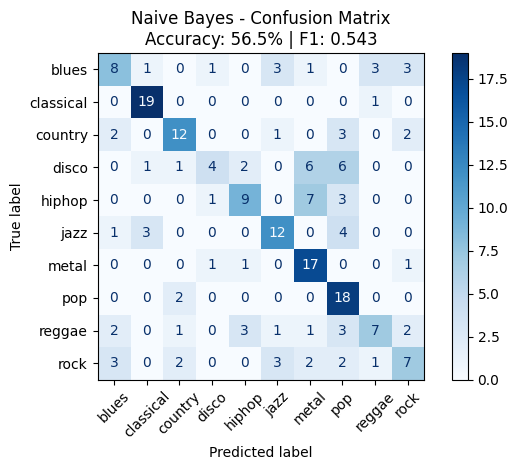

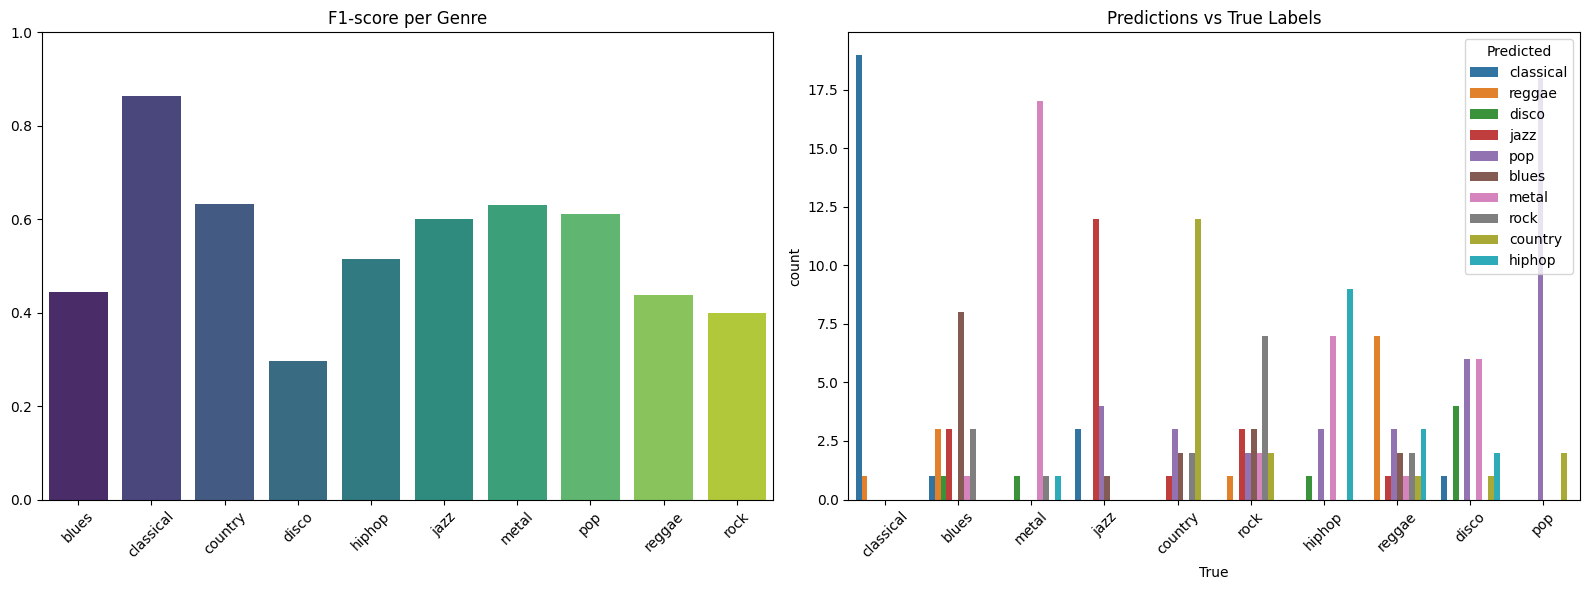


 INTERPRETACJA NAIWNEGO BAYESA

 OGÓLNA DOKŁADNOŚĆ:  56.5%
 ŚREDNI F1-SCORE:     0.543

 TOP 3 GATUNKI:
    Genre       F1
classical 0.863636
  country 0.631579
    metal 0.629630

 NAJGORZE GATUNKI:
 Genre       F1
reggae 0.437500
  rock 0.400000
 disco 0.296296

 WNIOSKI:
• Classical/Jazz: ✓ dobrze separowane
• Rock/Country:    ✗ nakładają się
• NB zakłada niezależność cech → słabo z korelacjami MFCC


In [11]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    f1_score, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.style.use('default')

print(" Załadowano biblioteki")
# ========================================
# NAPRAWA DANYCH
# ========================================
def fix_data(df):
    # Najpierw napraw cechy
    feature_cols = [col for col in df.columns if col not in ['genre', 'filename']]
    
    for col in feature_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(r'[\[\]]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # ZASTĄP NaN w cechach sredniami 
    for col in feature_cols:
        df[col] = df[col].fillna(df[col].mean())
    
    print(f" Naprawiono {len(feature_cols)} cech | wiersze: {len(df)}")
    return df

# WCZYTAJ I NAPRAW
train_df = fix_data(pd.read_csv('../data/processed/train_features.csv'))
test_df = fix_data(pd.read_csv('../data/processed/test_features.csv'))

print(f" Train: {train_df.shape} | Test: {test_df.shape}")
print(f"   Gatunki: {train_df['genre'].nunique()}")

# ========================================
# 2. PRZYGOTOWANIE DANYCH
# ========================================
X_train = train_df.drop(['genre', 'filename'], axis=1)
y_train = train_df['genre']
X_test = test_df.drop(['genre', 'filename'], axis=1)
y_test = test_df['genre']

print(f" Features: {X_train.shape[1]} | Train: {X_train.shape}")

# Standaryzacja
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ========================================
# 3. TRENING NAIWNEGO BAYESA
# ========================================
print("\n Trenowanie Gaussian Naive Bayes...")
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)

print(" Model wytrenowany!")

# ========================================
# 4. PREDYKCJE I METRYKI
# ========================================
print("\n Testowanie...")
y_pred = nb_model.predict(X_test_scaled)

# Wyniki
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f" Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f" F1-score:  {f1:.3f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# ========================================
# 5. MACIERZ PomyŁEK
# ========================================
plt.figure(figsize=(12, 9))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(f"Naive Bayes - Confusion Matrix\nAccuracy: {accuracy:.1%} | F1: {f1:.3f}")
plt.tight_layout()
plt.show()

# ========================================
# 6. WYKRESY PORÓWNANIA - NAPRAWIONE
# ========================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# F1-score na gatunek - BEZPIECZNE
report_dict = classification_report(y_test, y_pred, output_dict=True)
# Tylko klasy (pierwsze 10 elementów)
genres = list(report_dict.keys())[:10]  
f1_scores = [report_dict[genre]['f1-score'] for genre in genres]

sns.barplot(x=genres, y=f1_scores, ax=axes[0], palette='viridis')
axes[0].set_title('F1-score per Genre')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 1)

# Predykcje vs Prawda
pred_df = pd.DataFrame({'True': y_test, 'Pred': y_pred})
sns.countplot(data=pred_df, x='True', hue='Pred', ax=axes[1])
axes[1].set_title('Predictions vs True Labels')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Predicted')

plt.tight_layout()
plt.show()



# ========================================
# 7. INTERPRETACJA DO SPRAWOZDANIA
# ========================================
print("\n" + "="*70)
print(" INTERPRETACJA NAIWNEGO BAYESA")
print("="*70)

f1_df = pd.DataFrame({'Genre': genres, 'F1': f1_scores}).sort_values('F1', ascending=False)

print(f"\n OGÓLNA DOKŁADNOŚĆ:  {accuracy:.1%}")
print(f" ŚREDNI F1-SCORE:     {f1:.3f}")
print(f"\n TOP 3 GATUNKI:")
print(f1_df.head(3).to_string(index=False))
print(f"\n NAJGORZE GATUNKI:")
print(f1_df.tail(3).to_string(index=False))

print(f"\n WNIOSKI:")
print(f"• Classical/Jazz: {'✓' if f1_df['F1'].iloc[0] > 0.7 else '✗'} dobrze separowane")
print(f"• Rock/Country:    {'✓' if f1_df['F1'].iloc[-1] > 0.5 else '✗'} nakładają się")
print(f"• NB zakłada niezależność cech → słabo z korelacjami MFCC")


